In [8]:
import os
#os.chdir('../')

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from dateutil.relativedelta import relativedelta


In [333]:
quantiles = df_centered.groupby('relative_period')['issue_comments'].quantile(
            [0.10, 0.25, 0.50, 0.75, 0.90]
        ).unstack()
(quantiles - quantiles.loc[-3])/quantiles.loc[-3]*100

,0.10,0.25,0.50,0.75,0.90
relative_period,,,,,
-3.0,0.000000,0.0,0.000000,0.000000,0.000000
-2.0,100.000000,25.0,10.526316,-4.166667,-6.603774
-1.0,100.000000,25.0,-5.263158,-20.833333,-23.773585
0.0,33.333333,-12.5,-36.842105,-54.166667,-60.377358
1.0,-100.000000,-87.5,-89.473684,-93.750000,-95.283019
2.0,-100.000000,-87.5,-89.473684,-93.750000,-93.396226


In [357]:
def plot_percentiles_and_mean(df, criteria, plotcols, plotcoldict, month_interval, periods_before, periods_after,
                              window, criteria_pct, pre, post, threshold_mean, nobs, diff = False):
    colname = criteria_dict[criteria]
    
    df_subset = df.query(f'max_periods >= {periods_before}')
    df_actors = df_subset[['actor_id','repo_name','final_period']].drop_duplicates()
    df_actors['start_period'] = df_actors['final_period'].apply(lambda x: x - relativedelta(months = (periods_before-1)*month_interval))
    df_actors['end_period'] = df_actors['final_period'].apply(lambda x: x + relativedelta(months = periods_after*month_interval))
    df_centered = pd.merge(df_subset, df_actors).query('time_period >= start_period & time_period <= end_period')
    df_centered['relative_period'] = (df_centered['time_period'] - df_centered['final_period']).apply(lambda x: round(x.days/30.4)/6)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
    axes = axes.flatten()
    
    for i, plotcol in enumerate(plotcols):
        ax = axes[i]
        
        plotcolname = plotcoldict[plotcol]
        
        percentiles = df_centered.groupby('relative_period')[plotcol].quantile(
            [0.10, 0.50, 0.90]
        ).unstack()
        percentiles_diff = (percentiles - percentiles.loc[-periods_before+1])/percentiles.loc[-periods_before+1] * 100
        
        mean_values = df_centered.groupby('relative_period')[plotcol].mean()
        mean_values_diff = (mean_values - mean_values.loc[-periods_before+1])/mean_values.loc[-periods_before+1] * 100
        difference_str = ""
        if diff == True:
            mean_values = mean_values_diff
            percentiles = percentiles_diff
            difference_str = "% Change from First Pre Period"
        plt.figure(figsize=(10, 6))
        for col in percentiles.columns:
           ax.plot(percentiles.index, percentiles[col], label=f'{(col*100):.1f}th Pct')
        ax.plot(mean_values.index, mean_values, linestyle='-', linewidth=1.5, label='Mean')
        
        ax.axvline(x=1, color='red', linestyle='--')
        ax.set_title(f"Event Study of Percentiles of {plotcolname}")
        ax.set_ylabel(f"{colname}, {difference_str}")
        ax.set_xlabel("Time Relative to Departure", fontsize = 12)
        ax.legend()

    fig.suptitle(f"Obs: {nobs}, Window: {window}D, Criteria: {colname} ({criteria_pct} pct), Pre: {pre}, Post: {post}, Threshold Mean: {threshold_mean}", fontsize = 14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    diff_str = "differenced" if diff else ""
    fig.savefig(Path('issue/departure_eventstudy_plots') / f'contributors_major_months{major_months}_window{window}D_criteria_{criteria}_{criteria_pct}pct_general25pct_consecutive{pre}_post_period{post}threshold_mean_{threshold_mean}_{diff_str}.png')
    plt.show()



In [359]:
indir = Path('drive/output/derived/major_contributor_prospects/departed_contributors')
indir_cov = Path('drive/output/derived/major_contributor_prospects/contributor_data')
indir_hierarchy = Path('drive/output/derived/major_contributor_prospects/contributor_rank_panel')

In [347]:
for criteria_pct in criteria_pct_list:
    df_ic = pd.read_parquet(indir / f'contributors_major_months6_window732D_criteria_issue_comments_{criteria_pct}pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet')
    df_commits = pd.read_parquet(indir / f'contributors_major_months6_window732D_criteria_commits_{criteria_pct}pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet')
    df_ic_indiv = df_ic[['repo_name','actor_id']].drop_duplicates()
    df_commits_indiv = df_commits[['repo_name','actor_id']].drop_duplicates()
    overlapping_indiv = df_ic_indiv.merge(df_commits_indiv)
    print("Criteria PCT: {}, Issue Comment Departures: {}, Commit Departures: {}, Overlap: {}".format(
        criteria_pct, df_ic_indiv.shape[0], df_commits_indiv.shape[0], overlapping_indiv.shape[0]))

Criteria PCT: 75, Issue Comment Departures: 3543, Commit Departures: 704, Overlap: 248
Criteria PCT: 90, Issue Comment Departures: 2344, Commit Departures: 357, Overlap: 131


In [261]:
df_contributor = pd.read_parquet(indir_cov / 'major_contributors_major_months6_window732D_samplefull.parquet')

In [350]:
df_contributor.columns.tolist()

['repo_name',
 'actor_id',
 'time_period',
 'issue_comments',
 'linked_pr_issue_comments',
 'issue_number',
 'linked_pr_issue_number',
 'issue_comments_10th_pct',
 'issue_comments_25th_pct',
 'issue_comments_50th_pct',
 'issue_comments_75th_pct',
 'issue_comments_90th_pct',
 'linked_pr_issue_comments_10th_pct',
 'linked_pr_issue_comments_25th_pct',
 'linked_pr_issue_comments_50th_pct',
 'linked_pr_issue_comments_75th_pct',
 'linked_pr_issue_comments_90th_pct',
 'issue_number_10th_pct',
 'issue_number_25th_pct',
 'issue_number_50th_pct',
 'issue_number_75th_pct',
 'issue_number_90th_pct',
 'linked_pr_issue_number_10th_pct',
 'linked_pr_issue_number_25th_pct',
 'linked_pr_issue_number_50th_pct',
 'linked_pr_issue_number_75th_pct',
 'linked_pr_issue_number_90th_pct',
 'general_issue_comments_25th_pct',
 'general_issue_comments_50th_pct',
 'general_linked_pr_issue_comments_25th_pct',
 'general_linked_pr_issue_comments_50th_pct',
 'general_issue_number_25th_pct',
 'general_issue_number_50th

In [394]:
major_months_list = [6]
window_list = [732] #[367, 732, 1828]
criteria_list = ['issue_comments','commits']
criteria_pct_list = [75, 90]
consecutive_pre = [3] #[3, 6]
consecutive_post = [2] #[2, 4]
threshold_mean_list = [.2] #[.1, .2]
criteria_dict = {'issue_comments':'Issue Comments',
                 'commits':'Commits',
                 #'prs_merged': "PRs Merged",
                 #'issues_closed':"Issues Closed"
                 #'pr': 'PRs Opened',
                 #'pr_reviews': 'PR Reviews',
                 #'push_commits': 'Push Commits',
                 #'pr_commits': 'PR Commits'
                }
plotcols = list(criteria_dict.keys())

for major_months in major_months_list:
    for window in window_list:
        for criteria in criteria_list:
            for criteria_pct in criteria_pct_list:
                for pre in consecutive_pre:
                    for post in consecutive_post:
                        for threshold_mean in threshold_mean_list: 
                            try:
                                df = pd.read_parquet(indir / f'contributors_major_months{major_months}_window{window}D_criteria_{criteria}_{criteria_pct}pct_general25pct_consecutive{pre}_post_period{post}threshold_mean_{threshold_mean}.parquet')
                                df_details = pd.merge(df, df_contributor)
                                df_details['max_periods'] = df_details.groupby(['actor_id','repo_name'])['consecutive_periods'].transform('max')
                                nobs = df_details[['actor_id','repo_name']].drop_duplicates().shape[0]
                                plot_percentiles_and_mean(df_details, criteria, plotcols, criteria_dict, major_months, 5, 3,
                                                          window, criteria_pct, pre, post, threshold_mean, nobs)
                            except Exception as e:
                                print(e)


[Errno 2] No such file or directory: 'drive/output/derived/major_contributor_prospects/departed_contributors/contributors_major_months6_window732D_criteria_issue_comments_75pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet'
[Errno 2] No such file or directory: 'drive/output/derived/major_contributor_prospects/departed_contributors/contributors_major_months6_window732D_criteria_issue_comments_90pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet'
[Errno 2] No such file or directory: 'drive/output/derived/major_contributor_prospects/departed_contributors/contributors_major_months6_window732D_criteria_commits_75pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet'
[Errno 2] No such file or directory: 'drive/output/derived/major_contributor_prospects/departed_contributors/contributors_major_months6_window732D_criteria_commits_90pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet'


In [361]:
df_hierarchy = pd.read_parquet(indir_hierarchy / 'hierarchy_measure_major_months6_window732D.parquet')

<Axes: xlabel='time_period'>

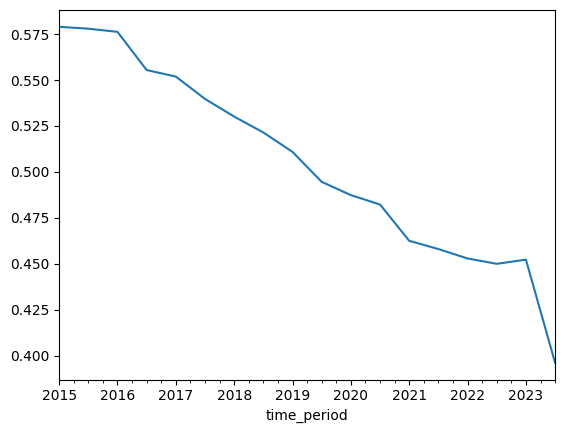

In [366]:
df_hierarchy.groupby('time_period')['project_hierarchy_rank'].mean().plot()

In [370]:
df_hierarchy

,repo_name,time_period,share_opened_issues,share_issue_comments,opened_issues,issue_comments,share_commits,share_pr,commits,pr,opened_issues_hr,issue_comments_hr,commits_hr,pr_hr,project_hierarchy_rank,active_user_hierarchy_rank,developer_hierarchy_rank
0,007gzs/django_restframework_apiview,2019-01-01,1.000000,1.000000,7.0,17.0,0.974359,0.0,39.0,1.0,3.5,1.19,3.9,0.77,0.907051,1.000000,0.813704
1,007gzs/django_restframework_apiview,2020-01-01,0.500000,0.500000,2.0,2.0,NaN,NaN,NaN,NaN,1.0,0.14,NaN,NaN,0.500000,0.500000,NaN
2,007gzs/django_restframework_apiview,2020-07-01,0.000000,0.000000,1.0,1.0,NaN,NaN,NaN,NaN,0.5,0.07,NaN,NaN,0.000000,0.000000,NaN
3,02strich/pykerberos,2015-01-01,0.800000,0.666667,5.0,6.0,0.857143,0.0,7.0,1.0,2.5,0.42,0.7,0.77,0.656036,0.780822,0.408163
4,02strich/pykerberos,2015-07-01,0.500000,0.565217,8.0,23.0,0.937500,0.0,16.0,1.0,4.0,1.61,1.6,0.77,0.552632,0.518717,0.632911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80267,zzzsochi/Flask-Gravatar,2017-01-01,0.666667,0.466667,9.0,15.0,0.000000,0.0,4.0,2.0,4.5,1.05,0.4,1.54,0.465955,0.628829,0.000000
80268,zzzsochi/Flask-Gravatar,2018-01-01,0.000000,0.000000,1.0,1.0,1.000000,1.0,4.0,1.0,0.5,0.07,0.4,0.77,0.672414,0.000000,1.000000
80269,zzzsochi/Flask-Gravatar,2022-07-01,NaN,NaN,0.0,0.0,0.000000,0.0,2.0,1.0,0.0,0.00,0.2,0.77,0.000000,NaN,0.000000
80270,zzzsochi/trans,2015-07-01,1.000000,1.000000,3.0,4.0,NaN,NaN,NaN,NaN,1.5,0.28,NaN,NaN,1.000000,1.000000,NaN


In [392]:
df_hierarchy['project_hierarchy_rank'] = 1 - df_hierarchy['project_hierarchy_rank']

In [393]:
df_hierarchy[['opened_issues','issue_comments','commits','pr','project_hierarchy_rank']].corr().loc[['project_hierarchy_rank']].round(3)

,opened_issues,issue_comments,commits,pr,project_hierarchy_rank
project_hierarchy_rank,-0.057,-0.046,-0.109,-0.087,1.0
